## DEFINE PROBLEM STATEMENT

## IMPORT LIBRARIES

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
# for EDA
from scipy.stats import skew
import scipy.stats
import pingouin

In [335]:
from sklearn.preprocessing import LabelEncoder

In [5]:
# for preprocessing
# -------  duplicate handling will be done manually
# -------  handling missing values
# -------  nothing for transformation
# -------  nothing for outlier handling
from sklearn.preprocessing import MinMaxScaler  #outlier handling
from sklearn.preprocessing import OneHotEncoder

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.feature_selection import f_regression,mutual_info_regression

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## LOAD DATA

In [11]:
dataset = pd.read_csv('datasets_13720_18513_insurance(1).csv')
dataset
df_m = dataset.copy() #for manual way
df_f = dataset.copy() #for fully automated pipeline

## BASIC CHECK

In [13]:
df_m.shape

(1338, 7)

In [14]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [15]:
df_m.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [16]:
df_m.describe(include='O')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


## DOMAIN ANALYSIS

## EDA

In [19]:
# STATISTICAL EDA

In [20]:
numeric = [ col for col in df_m.select_dtypes(include=np.number).columns]
categoric = [ col for col in df_m.columns if col not in numeric]
print(numeric)
print(categoric)

['age', 'bmi', 'children', 'charges']
['sex', 'smoker', 'region']


In [21]:
# normal and non normal col

In [22]:
normal=[]
non_normal=[]
uncertain=[]
for col in numeric:
    p = pingouin.normality(df_m[col]).loc[col,'pval']
    if p>0.05:
        normal.append(col)
    elif p<0.01:
        non_normal.append(col)
    else:
        uncertain.append(col)
print(normal)
print(non_normal)
print(uncertain)

[]
['age', 'bmi', 'children', 'charges']
[]


In [23]:
non_normal.remove('charges')
print(non_normal)

['age', 'bmi', 'children']


In [24]:
# checking skewness

In [25]:
normal_moderate=[]
normal_heavy=[]
non_normal_moderate=[]
non_normal_heavy=[]
normal_fairly=[]
non_normal_fairly=[]
uncertain_moderate=[]
uncertain_heavy=[]
uncertain_fairly=[]
skewness = abs(df_m[numeric].skew())
for col in normal:
    if 0.5<=skewness[col]<=1.0:
        normal_moderate.append(col)
    elif skewness[col]>1.0:
        normal_heavy.append(col)
    elif skewness[col]<0.5:
        normal_fairly.append(col)
for col in non_normal:
    if 0.5<=skewness[col]<=1.0:
        non_normal_moderate.append(col)
    elif skewness[col]>1.0:
        non_normal_heavy.append(col)
    elif (skewness[col]<0.5):
        non_normal_fairly.append(col)
for col in uncertain:
    if 0.5<=skewness[col]<=1.0:
        uncertain_moderate.append(col)
    elif skewness[col]>1.0:
        uncertain_heavy.append(col)
    elif (skewness[col]<0.5):
        uncertain_fairly.append(col)
print('normal_moderate',normal_moderate)
print('normal_heavy',normal_heavy)
print('normal_fairly',normal_fairly)
print('non_normal_moderate',non_normal_moderate)
print('non_normal_heavy',non_normal_heavy)
print('non_normal_fairly',non_normal_fairly)
print('uncertain_moderate',uncertain_moderate)
print('uncertain_heavy',uncertain_heavy)
print('uncertain_fairly',uncertain_fairly)

normal_moderate []
normal_heavy []
normal_fairly []
non_normal_moderate ['children']
non_normal_heavy []
non_normal_fairly ['age', 'bmi']
uncertain_moderate []
uncertain_heavy []
uncertain_fairly []


In [26]:
# VIZUALIZATION EDA

# MANUAL WAY DS

## create X, y

In [29]:
df_m.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [30]:
X = df_m.drop(columns='charges')
y = df_m['charges']

## split in train test data

In [32]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=42)

In [33]:
y.skew()

1.5158796580240388

In [34]:
ytrain = np.log1p(ytrain)
ytest = np.log1p(ytest)

## DATA PREPROCESSING

In [36]:
# duplicate handling

In [37]:
df_m.duplicated().sum()

1

In [38]:
df_m.drop_duplicates(inplace=True)

In [39]:
df_m.duplicated().sum()

0

In [40]:
# missing value handling

In [41]:
df_m.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [42]:
# creating copies for experimentation
# method 1: learning from train and applying to test  
xtrain_m1 = xtrain.copy()
xtest_m1 = xtest.copy()
ytrain_m1 = ytrain.copy()
ytest_m1 = ytest.copy()
# method 2
'''xtrain_m1 = xtrain.copy()
xtest_m1 = xtest.copy()
ytrain_m1 = ytrain.copy()
ytest_m1 = ytest.copy()'''

'xtrain_m1 = xtrain.copy()\nxtest_m1 = xtest.copy()\nytrain_m1 = ytrain.copy()\nytest_m1 = ytest.copy()'

In [43]:
# OUTLIER HANDLING

In [44]:
# outliers in xtrain

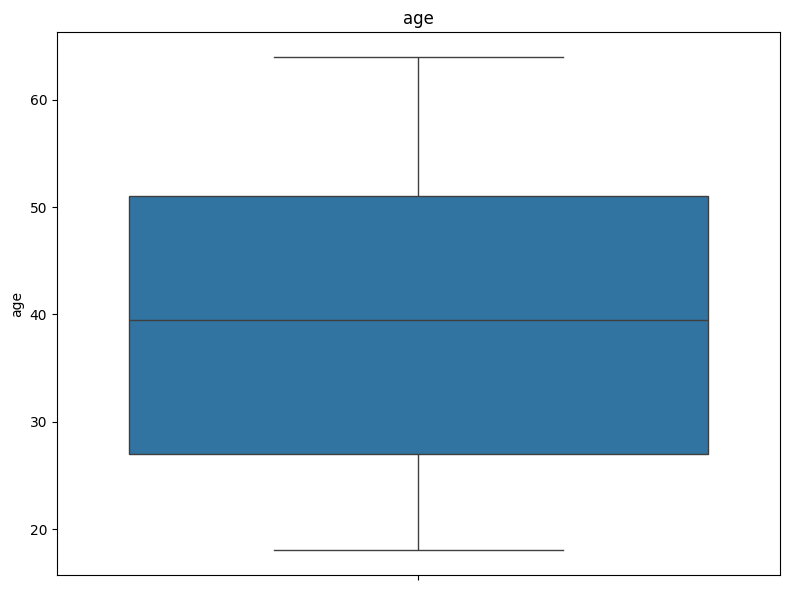

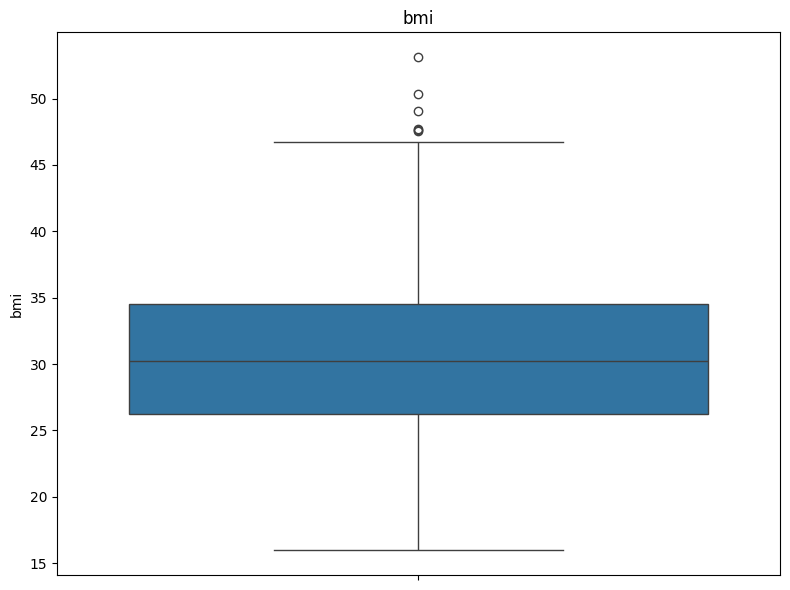

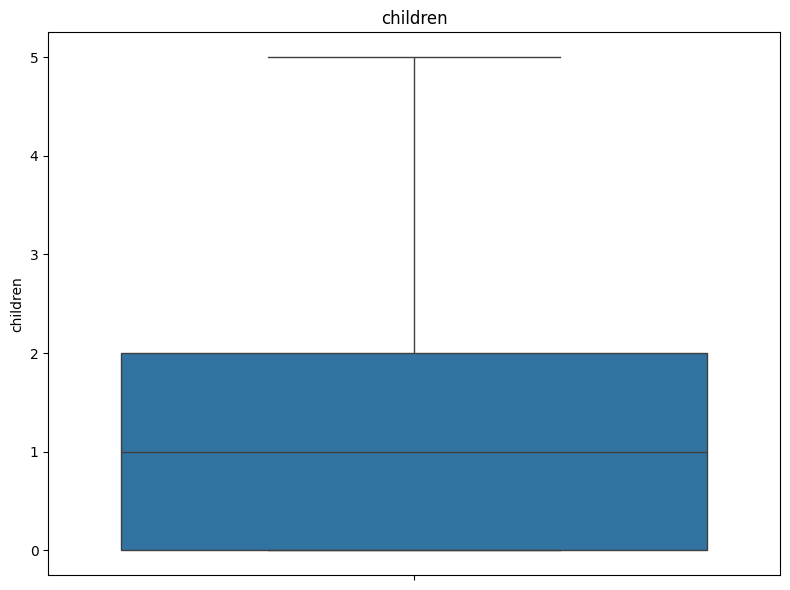

In [45]:
for col in numeric:
    if (col != 'charges'):
        plt.figure(figsize=(8,6))
        sns.boxplot(xtrain[col])
        plt.title(f'{col}')
        plt.tight_layout()
        plt.show()

In [46]:
# handling outliers using iqr method
q1=np.quantile(xtrain['bmi'],0.25)
q3=np.quantile(xtrain['bmi'],0.75)
iqr=q3-q1
ll=q1-(1.5*iqr)
ul=q3+(1.5*iqr)
print(ll,ul)

13.76812499999999 46.93312500000001


In [47]:
xtrain.loc[xtrain['bmi']<ll]

,age,sex,bmi,children,smoker,region


In [48]:
xtrain.loc[xtrain['bmi']>ul]

,age,sex,bmi,children,smoker,region
847,23,male,50.38,1,no,southeast
1088,52,male,47.74,1,no,southeast
1317,18,male,53.13,0,no,southeast
116,58,male,49.06,0,no,southeast
401,47,male,47.52,1,no,southeast
860,37,female,47.60,2,yes,southwest


In [49]:
((len(xtrain.loc[xtrain['bmi']>ul])/len(xtrain))*100)<5

True

In [50]:
median_xtrain = xtrain['bmi'].median()
xtrain.loc[xtrain['bmi']>ul,'bmi'] = median_xtrain

In [51]:
# outliers in xtest

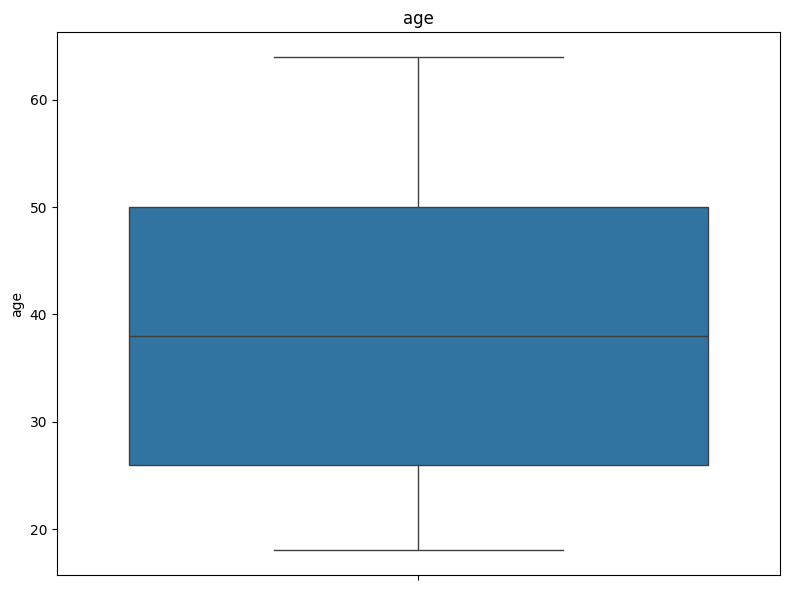

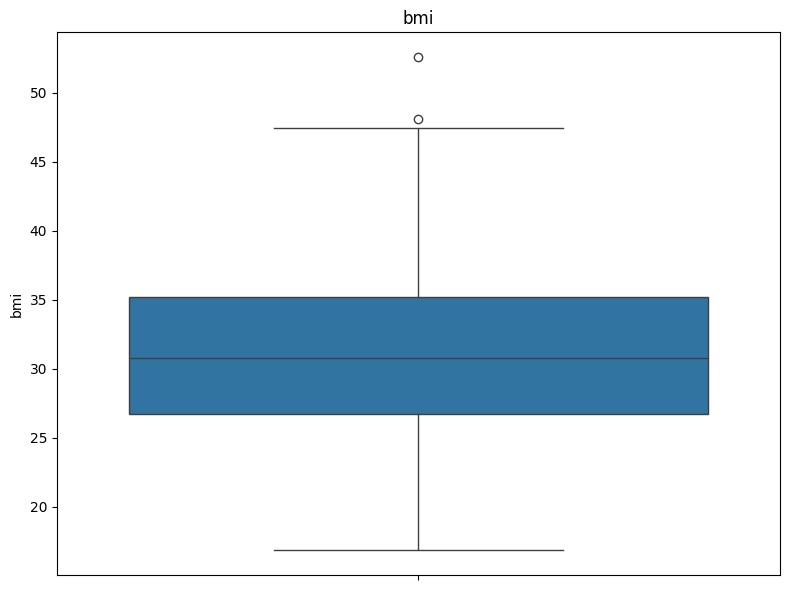

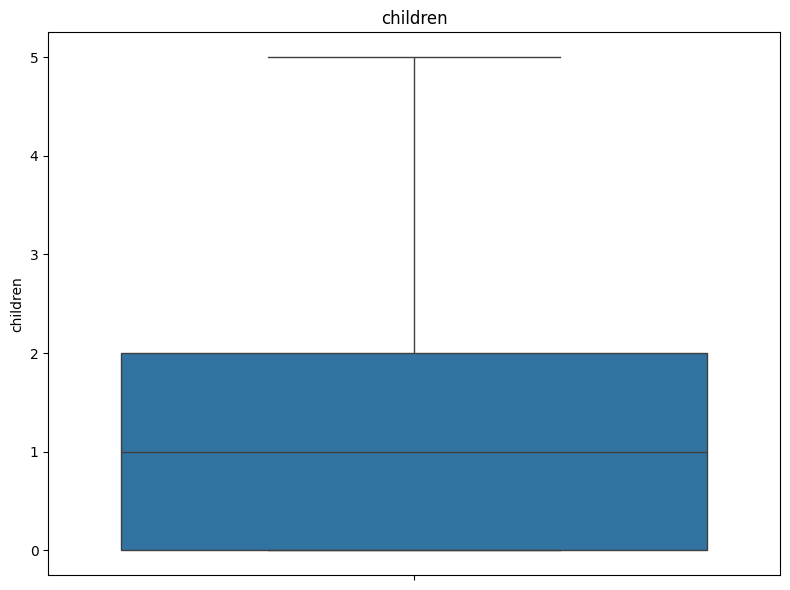

In [52]:
for col in numeric:
    if (col != 'charges'):
        plt.figure(figsize=(8,6))
        sns.boxplot(xtest[col])
        plt.title(f'{col}')
        plt.tight_layout()
        plt.show()

In [53]:
# handling outliers using iqr method
q1=np.quantile(xtest['bmi'],0.25)
q3=np.quantile(xtest['bmi'],0.75)
iqr=q3-q1
ll=q1-(1.5*iqr)
ul=q3+(1.5*iqr)
print(ll,ul)

13.878124999999997 47.993125000000006


In [54]:
xtest.loc[xtest['bmi']<ll]

,age,sex,bmi,children,smoker,region


In [55]:
xtest.loc[xtest['bmi']>ul]

,age,sex,bmi,children,smoker,region
1047,22,male,52.58,1,yes,southeast
286,46,female,48.07,2,no,northeast


In [56]:
((len(xtest.loc[xtest['bmi']>ul])/len(xtest))*100)<5

True

In [57]:
xtest.loc[xtest['bmi']>ul,'bmi'] = xtest['bmi'].median()

In [58]:
xtest.loc[xtest['bmi']>ul]

,age,sex,bmi,children,smoker,region


In [59]:
# outlier handling in ytrain

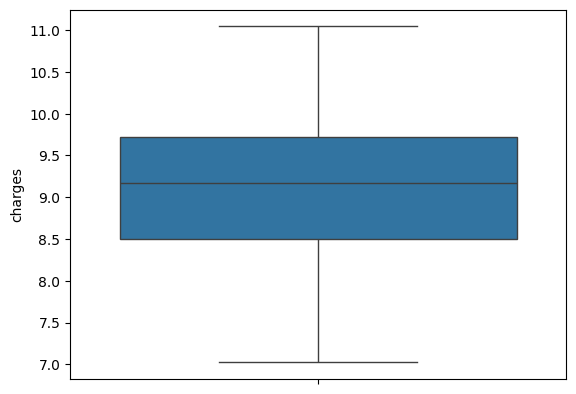

In [60]:
sns.boxplot(ytrain)
plt.show()

In [61]:
pingouin.normality(ytrain)

,W,pval,normal
charges,0.983108,8.294878e-10,False


In [62]:
ytrain.skew()

-0.12387621192771353

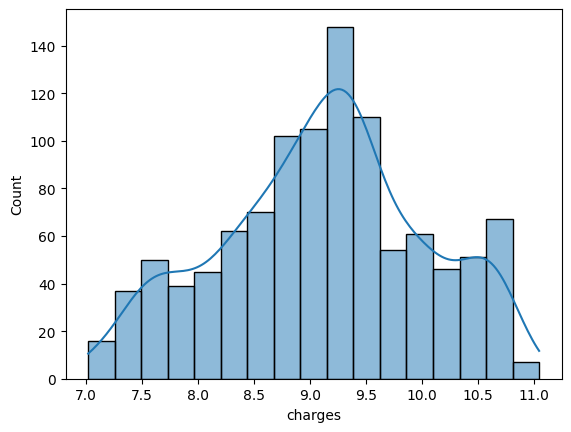

In [63]:
sns.histplot(ytrain,kde=True)
plt.show()

In [64]:
# handling outliers using iqr method
q1=np.quantile(ytrain,0.25)
q3=np.quantile(ytrain,0.75)
iqr=q3-q1
ll=q1-(1.5*iqr)
ul=q3+(1.5*iqr)
print(ll,ul)

print(ytrain.loc[ytrain<ll])

print(ytrain.loc[ytrain>ul])

print(((len(ytrain.loc[ytrain>ul])/len(ytrain))*100)<5)

6.652781448638656 11.569945465560473
Series([], Name: charges, dtype: float64)
Series([], Name: charges, dtype: float64)
True


In [65]:
# outlier handling in ytest

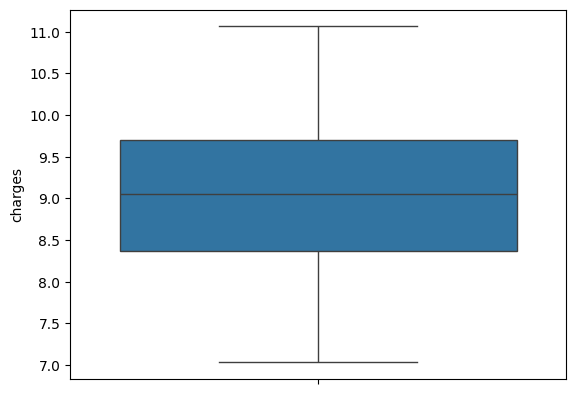

In [66]:
sns.boxplot(ytest)
plt.show()

In [67]:
ytest.skew()

0.044884870330211504

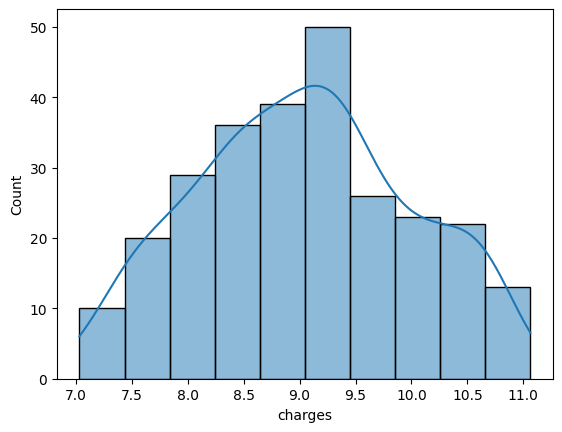

In [68]:
sns.histplot(ytest,kde=True)
plt.show()

In [69]:
# handling outliers using iqr method
q1=np.quantile(ytest,0.25)
q3=np.quantile(ytest,0.75)
iqr=q3-q1
ll=q1-(1.5*iqr)
ul=q3+(1.5*iqr)
print(ll,ul)

6.355284425919414 11.711800373816743


In [70]:
print(ytest.loc[ytest<ll])
print()
print(ytest.loc[ytest>ul])

Series([], Name: charges, dtype: float64)

Series([], Name: charges, dtype: float64)


In [71]:
ytest.loc[ytest>ul]

Series([], Name: charges, dtype: float64)

In [72]:
# multicollinearity based feature selection

In [73]:
corr_matrix = xtrain.drop(columns=['sex','region','smoker']).corr().abs()
mask = np.triu(np.ones(corr_matrix.shape),k=1).astype(bool)
corr_matrix = corr_matrix.where(mask)
multicollinearity_drop = [ col for col in corr_matrix.columns if any(corr_matrix[col]>0.9)]
print(multicollinearity_drop)

[]


In [74]:
# ENCODING

In [75]:
print(categoric)
print(df_m.sex.value_counts())
print(df_m.smoker.value_counts())
print(df_m.region.value_counts())

['sex', 'smoker', 'region']
sex
male      675
female    662
Name: count, dtype: int64
smoker
no     1063
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64


In [76]:
from sklearn.preprocessing import LabelEncoder
for col in ['smoker','sex']:
    le = LabelEncoder()
    xtrain[col] = le.fit_transform(xtrain[col])
    xtest[col] = le.transform(xtest[col])

In [77]:
# ohe to region cols
enc_xtrain = pd.get_dummies(xtrain['region'],prefix='region')
enc_xtest = pd.get_dummies(xtest['region'],prefix='region')
#index allignment
enc_xtest = enc_xtest.reindex(columns=enc_xtrain.columns,fill_value=0)
# drop original cols
xtrain = xtrain.drop(columns='region')
xtest = xtest.drop(columns='region')
# concatenate
xtrain = pd.concat([xtrain.reset_index(drop=True), enc_xtrain.reset_index(drop=True)],axis=1)
xtest = pd.concat([xtest.reset_index(drop=True), enc_xtest.reset_index(drop=True)],axis=1)

In [78]:
# SCALING

In [79]:
for col in xtrain.select_dtypes(include=np.number).columns:
    print(f'col range of {col}: {xtrain[col].max()-xtrain[col].min()}')

col range of age: 46
col range of sex: 1
col range of bmi: 30.740000000000002
col range of children: 5
col range of smoker: 1


In [80]:
# dataset for ms xtrain_ms 
# dataset for sc xtrain_sc
# dataset for xtrain_ms_comp
# dataset for xtrain_sc_comp
#xtrain_ms = xtrain.copy()
xtrain_sc = xtrain.copy()
xtest_sc = xtest.copy()
#xtrain_ms_comp = xtrain.copy()
#xtrain_sc_comp = xtrain.copy()

In [81]:
for col in ['age','bmi']:
    ms = MinMaxScaler()
    xtrain_sc[[col]] = ms.fit_transform(xtrain_sc[[col]])
    xtest_sc[[col]] = ms.transform(xtest_sc[[col]])

## MODEL CREATION

In [83]:
# linear regression
lin_reg = LinearRegression()
lin_reg.fit(xtrain_sc, ytrain)
lin_reg_ypred = lin_reg.predict(xtest_sc)
#evaluate
lin_reg_mse = mean_squared_error(ytest,lin_reg_ypred)
lin_reg_rmse = np.sqrt(mean_squared_error(ytest,lin_reg_ypred))
lin_reg_mae = mean_absolute_error(ytest,lin_reg_ypred)
lin_reg_r2 = r2_score(ytest,lin_reg_ypred)

In [84]:
# Step 3: Inverse transform ytest and ypred
ytest_true = np.expm1(ytest)               # actual charges
ypred_true = np.expm1(lin_reg_ypred)       # predicted charges

# Step 4: Evaluate in original scale
mse_orig = mean_squared_error(ytest_true,ypred_true)
rmse_orig = np.sqrt(mean_squared_error(ytest_true, ypred_true))
mae_orig = mean_absolute_error(ytest_true, ypred_true)
r2_orig = r2_score(ytest_true, ypred_true)
print('Linear regression')
print("Original scale MSE:", mse_orig)
print("Original scale RMSE:", rmse_orig)
print("Original scale MAE:", mae_orig)
print("Original scale R2:", r2_orig)

Linear regression
Original scale MSE: 61446954.01997477
Original scale RMSE: 7838.810752912381
Original scale MAE: 3903.858665234291
Original scale R2: 0.6042031813752322


In [85]:
# SVM REGRESSOR
svm_reg = SVR()
svm_reg.fit(xtrain_sc, ytrain)
svm_reg_ypred = svm_reg.predict(xtest_sc)
#evaluate
svm_reg_mse = mean_squared_error(ytest,svm_reg_ypred)
svm_reg_rmse = np.sqrt(mean_squared_error(ytest,svm_reg_ypred))
svm_reg_mae = mean_absolute_error(ytest,svm_reg_ypred)
svm_reg_r2 = r2_score(ytest,svm_reg_ypred)
'''print('mse',svm_reg_mse)
print('rmse',svm_reg_rmse)
print('mae',svm_reg_mae)
print('r2',svm_reg_r2)'''

"print('mse',svm_reg_mse)\nprint('rmse',svm_reg_rmse)\nprint('mae',svm_reg_mae)\nprint('r2',svm_reg_r2)"

In [86]:
ytest_true = np.expm1(ytest)
svm_reg_ypred_true = np.expm1(svm_reg_ypred)

mse_orig = mean_squared_error(ytest_true,svm_reg_ypred_true)
rmse_orig = np.sqrt(mean_squared_error(ytest_true, svm_reg_ypred_true))
mae_orig = mean_absolute_error(ytest_true, svm_reg_ypred_true)
r2_orig = r2_score(ytest_true, svm_reg_ypred_true)
print('Support regression')
print("Original scale MSE:", mse_orig)
print("Original scale RMSE:", rmse_orig)
print("Original scale MAE:", mae_orig)
print("Original scale R2:", r2_orig)

Support regression
Original scale MSE: 24179134.497399107
Original scale RMSE: 4917.228334885325
Original scale MAE: 2294.3230220150413
Original scale R2: 0.8442555100768708


In [87]:
# KNN REGRESSOR

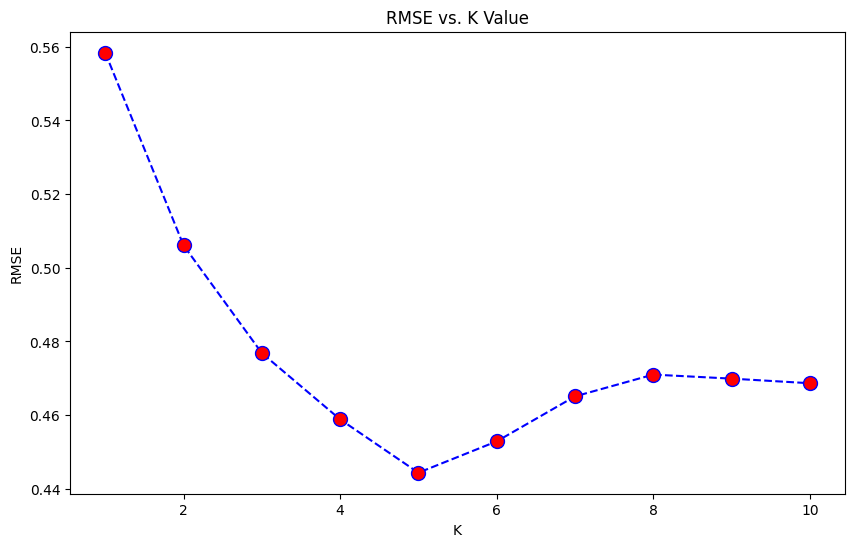

In [88]:
# finding optimal value of neighbors
from sklearn.metrics import mean_squared_error

rmse_list = []
for i in range(1, 11):
    knn_n = KNeighborsRegressor(n_neighbors=i)
    knn_n.fit(xtrain_sc, ytrain)
    pred_i = knn_n.predict(xtest_sc)
    rmse = np.sqrt(mean_squared_error(ytest, pred_i))
    rmse_list.append(rmse)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), rmse_list, color='blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('RMSE vs. K Value')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()


In [89]:

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(xtrain_sc,ytrain)
knn_reg_ypred = knn_reg.predict(xtest_sc)
#evaluate
knn_reg_mse = mean_squared_error(ytest, knn_reg_ypred)
knn_reg_rmse = np.sqrt(knn_reg_mse)
knn_reg_mae = mean_absolute_error(ytest, knn_reg_ypred)
knn_reg_r2 = r2_score(ytest, knn_reg_ypred)

In [90]:
# Step 3: Inverse transform ytest and ypred
ytest_true = np.expm1(ytest)               
ypred_true = np.expm1(knn_reg_ypred)       

# Step 4: Evaluate in original scale
mse_orig = mean_squared_error(ytest_true,ypred_true)
rmse_orig = np.sqrt(mean_squared_error(ytest_true, ypred_true))
mae_orig = mean_absolute_error(ytest_true, ypred_true)
r2_orig = r2_score(ytest_true, ypred_true)
print('KNN regression')
print("Original scale MSE:", mse_orig)
print("Original scale RMSE:", rmse_orig)
print("Original scale MAE:", mae_orig)
print("Original scale R2:", r2_orig)

KNN regression
Original scale MSE: 43307961.6235794
Original scale RMSE: 6580.878484182746
Original scale MAE: 3762.335171393894
Original scale R2: 0.7210414461526583


In [91]:
# Decision Tree Regressor

In [92]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(xtrain_sc,ytrain)
dt_reg_ypred = dt_reg.predict(xtest_sc)
#evaluate
dt_reg_mse = mean_squared_error(dt_reg_ypred,ytest)
dt_reg_rmse = np.sqrt(mean_squared_error(dt_reg_ypred,ytest))
dt_reg_mae = mean_absolute_error(dt_reg_ypred, ytest)
dt_reg_r2 = r2_score(dt_reg_ypred, ytest)

In [93]:
# Step 3: Inverse transform ytest and ypred
ytest_true = np.expm1(ytest)               
ypred_true = np.expm1(dt_reg_ypred)       

# Step 4: Evaluate in original scale
mse_orig = mean_squared_error(ytest_true,ypred_true)
rmse_orig = np.sqrt(mean_squared_error(ytest_true, ypred_true))
mae_orig = mean_absolute_error(ytest_true, ypred_true)
r2_orig = r2_score(ytest_true, ypred_true)
print('Decision Tree regression')
print("Original scale MSE:", mse_orig)
print("Original scale RMSE:", rmse_orig)
print("Original scale MAE:", mae_orig)
print("Original scale R2:", r2_orig)

Decision Tree regression
Original scale MSE: 37694479.90286067
Original scale RMSE: 6139.583039821245
Original scale MAE: 2892.201319324627
Original scale R2: 0.7571994338333253


In [94]:
# RandomForest Regressor

In [95]:
rf_reg = RandomForestRegressor()
rf_reg.fit(xtrain_sc,ytrain)
rf_reg_ypred = rf_reg.predict(xtest_sc)
#evaluate
rf_reg_mse = mean_squared_error(ytest,rf_reg_ypred)
rf_reg_rmse = np.sqrt(mean_squared_error(ytest,rf_reg_ypred))
rf_reg_mae = mean_absolute_error(ytest,rf_reg_ypred)
rf_reg_r2 = r2_score(ytest,rf_reg_ypred)

In [96]:
# Step 3: Inverse transform ytest and ypred
ytest_true = np.expm1(ytest)               
ypred_true = np.expm1(rf_reg_ypred)       

# Step 4: Evaluate in original scale
mse_orig = mean_squared_error(ytest_true,ypred_true)
rmse_orig = np.sqrt(mean_squared_error(ytest_true, ypred_true))
mae_orig = mean_absolute_error(ytest_true, ypred_true)
r2_orig = r2_score(ytest_true, ypred_true)
print('Random Forest Regressor')
print("Original scale MSE:", mse_orig)
print("Original scale RMSE:", rmse_orig)
print("Original scale MAE:", mae_orig)
print("Original scale R2:", r2_orig)

Random Forest Regressor
Original scale MSE: 20231880.687891506
Original scale RMSE: 4497.986292541531
Original scale MAE: 2153.103306476443
Original scale R2: 0.8696808631317958


In [97]:
# Gradient Boosting Regressor

In [98]:
gb_reg = GradientBoostingRegressor()
gb_reg.fit(xtrain_sc,ytrain)
gb_reg_ypred = gb_reg.predict(xtest_sc)
#evaluate
gb_reg_mse = mean_squared_error(ytest,gb_reg_ypred)
gb_reg_rmse = np.sqrt(mean_squared_error(ytest,gb_reg_ypred))
gb_reg_mae = mean_absolute_error(ytest,gb_reg_ypred)
gb_reg_r2 = r2_score(ytest,gb_reg_ypred)

In [99]:
# Step 3: Inverse transform ytest and ypred
ytest_true = np.expm1(ytest)               
ypred_true = np.expm1(gb_reg_ypred)       

# Step 4: Evaluate in original scale
mse_orig = mean_squared_error(ytest_true,ypred_true)
rmse_orig = np.sqrt(mean_squared_error(ytest_true, ypred_true))
mae_orig = mean_absolute_error(ytest_true, ypred_true)
r2_orig = r2_score(ytest_true, ypred_true)
print('Gradient Boosting Regressor')
print("Original scale MSE:", mse_orig)
print("Original scale RMSE:", rmse_orig)
print("Original scale MAE:", mae_orig)
print("Original scale R2:", r2_orig)

Gradient Boosting Regressor
Original scale MSE: 19897845.136225566
Original scale RMSE: 4460.700072435443
Original scale MAE: 2026.078920980966
Original scale R2: 0.8718324784683994


In [100]:
# Extreme Gradient Boosting Regressor

In [101]:
xgb_reg = XGBRegressor()
xgb_reg.fit(xtrain_sc,ytrain)
xgb_reg_ypred = xgb_reg.predict(xtest_sc)
#evaluate
xgb_reg_mse = mean_squared_error(ytest,xgb_reg_ypred)
xgb_reg_rmse = np.sqrt(mean_squared_error(ytest,xgb_reg_ypred))
xgb_reg_mae = mean_absolute_error(ytest,xgb_reg_ypred)
xgb_reg_r2 = r2_score(ytest,xgb_reg_ypred)

In [102]:
# Step 3: Inverse transform ytest and ypred
ytest_true = np.expm1(ytest)               
ypred_true = np.expm1(xgb_reg_ypred)       

# Step 4: Evaluate in original scale
mse_orig = mean_squared_error(ytest_true,ypred_true)
rmse_orig = np.sqrt(mean_squared_error(ytest_true, ypred_true))
mae_orig = mean_absolute_error(ytest_true, ypred_true)
r2_orig = r2_score(ytest_true, ypred_true)
print('Extreme Gradient Boosting Regressor')
print("Original scale MSE:", mse_orig)
print("Original scale RMSE:", rmse_orig)
print("Original scale MAE:", mae_orig)
print("Original scale R2:", r2_orig)

Extreme Gradient Boosting Regressor
Original scale MSE: 28799335.766128816
Original scale RMSE: 5366.501259305621
Original scale MAE: 2684.297808364827
Original scale R2: 0.81449551639232


# FULLY AUTOMATED PIPELINE

In [104]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [105]:
from sklearn.model_selection import GridSearchCV

## BASIC CHECK

In [107]:
df_m.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [108]:
df_m.shape

(1337, 7)

In [109]:
df_m.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [110]:
df_m.describe(include='O')

,sex,smoker,region
count,1337,1337,1337
unique,2,2,4
top,male,no,southeast
freq,675,1063,364


In [111]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


## EDA

In [113]:
# we know that duplicates and missing values dont exist.

In [114]:
# checking skewness for transformations

In [115]:
moderate_positive_skew = []
moderate_negative_skew = []
high_positive_skew = []
high_negative_skew = []
for col in df_m.select_dtypes(include=np.number):
    if (0.5<df_m[col].skew()<=1.0):
        moderate_positive_skew.append(col)
    elif ( df_m[col].skew()<(-0.5) and df_m[col].skew()>=(-1.0) ):
        moderate_negative_skew.append(col)
    elif ( df_m[col].skew()>1.0 ):
        high_positive_skew.append(col)
    elif ( df_m[col].skew()<(-1.0) ):
        high_negative_skew.append(col)
print('moderate_positive_skew',moderate_positive_skew)
print('moderate_negative_skew',moderate_negative_skew)
print('high_positive_skew',high_positive_skew)
print('high_negative_skew',high_negative_skew)

moderate_positive_skew ['children']
moderate_negative_skew []
high_positive_skew ['charges']
high_negative_skew []


In [116]:
df_m.bmi.skew()

0.28391419385321137

In [117]:
df_m.age.skew()

0.054780773126998195

In [118]:
df_m.children.unique()

array([0, 1, 3, 2, 5, 4], dtype=int64)

In [119]:
# outlier handling

In [120]:
non_normal

['age', 'bmi', 'children']

In [121]:
iqr_outliers=[]
for col in non_normal:
    q1=np.quantile(df_m[col],0.25)
    q3=np.quantile(df_m[col],0.75)
    iqr=q3-q1
    ll=q1-(1.5*iqr)
    ul=q3+(1.5*iqr)
    #
    lo = df_m.loc[df_m[col]<ll]
    uo = df_m.loc[df_m[col]>ul]
    #
    if( len(lo)>0 or len(uo)>0 ):
        iqr_outliers.append(col)
print('iqr_outliers',iqr_outliers)

iqr_outliers ['bmi']


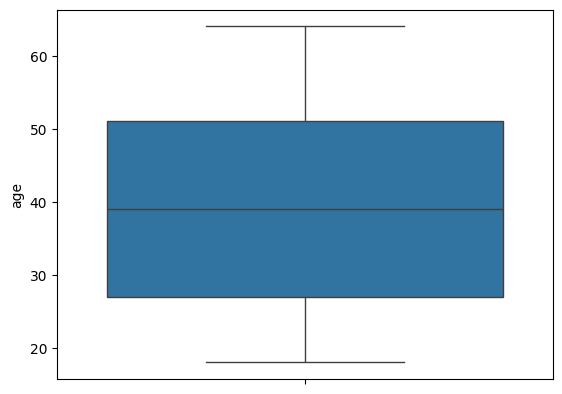

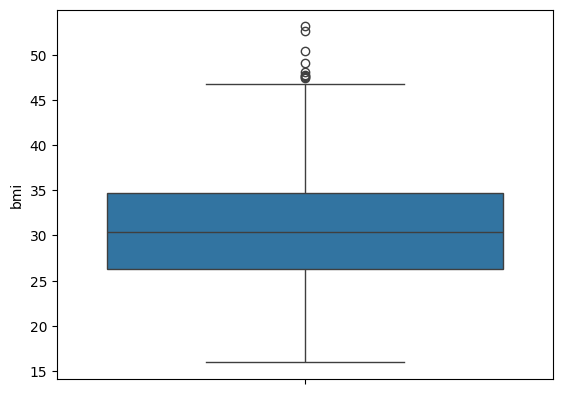

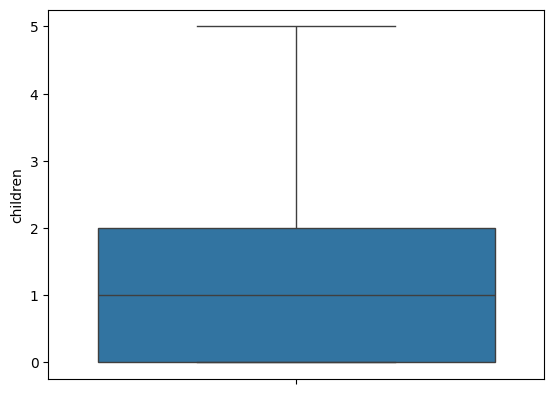

In [122]:
for col in non_normal:
    sns.boxplot(df_m[col])
    plt.show()

In [123]:
categoric

['sex', 'smoker', 'region']

In [124]:
# scaling

In [125]:
for col in numeric:
    print(f'{col}: {df_m[col].max()-df_m[col].min()}')

age: 46
bmi: 37.17
children: 5
charges: 62648.554110000005


## BUILD COLUMNTRANSFORMER

In [127]:
class iqr_outlier_handler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.ll_ = {}
        self.ul_ = {}
        self.median_ = {}
        self.columns_to_modify_ = []

    def fit(self, X, y=None):
        numeric_cols = X.select_dtypes(include=np.number).columns
        for col in numeric_cols:
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            iqr = q3 - q1
            ll = q1 - 1.5 * iqr
            ul = q3 + 1.5 * iqr
            median = X[col].median()

            outlier_mask = (X[col] < ll) | (X[col] > ul)
            outlier_ratio = outlier_mask.sum() / len(X)

            if outlier_ratio < 0.05:
                self.ll_[col] = ll
                self.ul_[col] = ul
                self.median_[col] = median
                self.columns_to_modify_.append(col)

        return self

    def transform(self, X, y=None):
        X = X.copy()
        for col in self.columns_to_modify_:
            ll = self.ll_[col]
            ul = self.ul_[col]
            median = self.median_[col]
            outlier_mask = (X[col] < ll) | (X[col] > ul)
            X.loc[outlier_mask, col] = median
        return X

In [128]:

class ModifiedLabelEncoder(LabelEncoder):
    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)
 

## TRANSFORMATIONS TO COLS

In [130]:
# bmi
bmi_pipeline = Pipeline([
                       ('outlier handling',iqr_outlier_handler()),
                       ('min max scaling',MinMaxScaler())
                        ])
# age
age_pipeline = Pipeline(
    [('min max scaling age',MinMaxScaler())
    ])
# sex
sex_pipeline = Pipeline([('label encoder',ModifiedLabelEncoder())])
# smoker
smoker_pipeline = Pipeline([('label encoder',ModifiedLabelEncoder())])
# region
region_pipeline = Pipeline([('ohe',OneHotEncoder(handle_unknown='ignore'))])

In [131]:
preprocessor = ColumnTransformer([('bmi pipeline',bmi_pipeline,['bmi']),
                                  ('age pipeline',age_pipeline,['age']),
                                  ('sex pipeline',sex_pipeline,['sex']),
                                  ('smoker pipeline',smoker_pipeline,['smoker']),
                                  ('region pipeline',region_pipeline,['region'])])

In [132]:
# data splitting, model in pipeline etc.

In [133]:
df_m

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [134]:
X = df_m.drop(columns='charges')
y = df_m['charges']

In [135]:
xtrainp,xtestp,ytrainp,ytestp = train_test_split(X,y,test_size=0.2,random_state=42)

In [136]:
model_pipeline = Pipeline([
('data pre-processing',preprocessor),
('model',GradientBoostingRegressor())
])

In [137]:
model_pipeline.fit(xtrainp,np.log1p(ytrainp))
ypred_model_pipeline = model_pipeline.predict(xtestp)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please c

In [138]:
ypred_model_pipeline_true = np.expm1(ypred_model_pipeline)

In [139]:
mse = mean_squared_error(ytestp, ypred_model_pipeline_true)
rmse = np.sqrt(mse)
mae = mean_absolute_error(ytestp, ypred_model_pipeline_true)
r2 = r2_score(ytestp, ypred_model_pipeline_true)
print("Final Model Evaluation Metrics")
print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)
print("R² Score:", r2)

Final Model Evaluation Metrics
MSE : 19834183.508521754
RMSE: 4453.558521959912
MAE : 2261.875499808044
R² Score: 0.8920624273706386


## PIPELINE HYPERPARAMETER TUNING

In [141]:
param_grid = {
'model__max_depth':[3,4,6,8,10], #5
'model__learning_rate':[0.01,0.04,0.07,0.1,0.3,0.6,0.8], #8
'model__n_estimators':[50,65,80,100,150] #5
}

In [142]:
model_pipeline_gcv = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [143]:
model_pipeline_gcv.fit(xtrainp, np.log1p(ytrainp))

Fitting 5 folds for each of 175 candidates, totalling 875 fits


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data pre-processing',
                                        ColumnTransformer(transformers=[('bmi '
                                                                         'pipeline',
                                                                         Pipeline(steps=[('outlier '
                                                                                          'handling',
                                                                                          iqr_outlier_handler()),
                                                                                         ('min '
                                                                                          'max '
                                                                                          'scaling',
                                                                                          MinMaxScaler())]),
                                                                         ['bmi']),
                                                                        ('age '
                                                                         'pipeline',
                                                                         Pipeline(steps=[('min '
                                                                                          'max '
                                                                                          'scaling '
                                                                                          'age',
                                                                                          MinMaxScaler())]),
                                                                         ['age']),
                                                                        ('sex '
                                                                         'pipeline',
                                                                         Pipeline(steps=[('label '...
                                                                                          'encoder',
                                                                                          ModifiedLabelEncoder())]),
                                                                         ['smoker']),
                                                                        ('region '
                                                                         'pipeline',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['region'])])),
                                       ('model', GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.04, 0.07, 0.1, 0.3,
                                                  0.6, 0.8],
                         'model__max_depth': [3, 4, 6, 8, 10],
                         'model__n_estimators': [50, 65, 80, 100, 150]},
             verbose=1)

In [144]:
model_pipeline_gcv_ypred = model_pipeline_gcv.predict(xtestp)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [145]:
model_pipeline_gcv_ypred_true = np.expm1(model_pipeline_gcv_ypred)

In [146]:
model_pipeline_gcv_mse = mean_squared_error(ytestp, model_pipeline_gcv_ypred_true)
model_pipeline_gcv_rmse = np.sqrt(mse)
model_pipeline_gcv_mae = mean_absolute_error(ytestp, model_pipeline_gcv_ypred_true)
model_pipeline_gcv_r2 = r2_score(ytestp, model_pipeline_gcv_ypred_true)
print("Final Hyperparameter Model Evaluation Metrics")
print("MSE :", model_pipeline_gcv_mse)
print("RMSE:", model_pipeline_gcv_rmse)
print("MAE :", model_pipeline_gcv_mae)
print("R² Score:", model_pipeline_gcv_r2)

Final Hyperparameter Model Evaluation Metrics
MSE : 19277199.615526095
RMSE: 4453.558521959912
MAE : 2108.062139513707
R² Score: 0.8950935321992176


In [147]:
print("Best Parameters:", model_pipeline_gcv.best_params_)
print("Best Score (CV R²):", model_pipeline_gcv.best_score_)
print("Best Estimator:\n", model_pipeline_gcv.best_estimator_)

Best Parameters: {'model__learning_rate': 0.07, 'model__max_depth': 3, 'model__n_estimators': 65}
Best Score (CV R²): 0.7948874053810577
Best Estimator:
 Pipeline(steps=[('data pre-processing',
                 ColumnTransformer(transformers=[('bmi pipeline',
                                                  Pipeline(steps=[('outlier '
                                                                   'handling',
                                                                   iqr_outlier_handler()),
                                                                  ('min max '
                                                                   'scaling',
                                                                   MinMaxScaler())]),
                                                  ['bmi']),
                                                 ('age pipeline',
                                                  Pipeline(steps=[('min max '
                                              

In [148]:
import pickle

In [149]:
with open('Insurance Cost Prediction full pkl','wb') as f:
    pickle.dump(model_pipeline_gcv,f)